# Fast Copula Covariance Demo

This notebook demonstrates the new fast copula covariance functionality in scDesigner, which reduces computational time by modeling only the top-k most prevalent genes with full covariance.

- **Gene selection**: Select the top `k` most prevalent (highly expressed) genes
- **Efficient covariance**: Compute full covariance matrix for top-k genes only
- **Diagonal approximation**: Use diagonal covariance for remaining genes


In [1]:
import numpy as np
import pandas as pd
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns
import time

from scdesigner.estimators import (
    negbin_copula,  # Regular estimator
    fast_negbin_copula_factory,  # Fast estimator factory
    FastCovarianceStructure
)


## Speed Test

In [2]:
# Example: Basic Usage Comparison
def generate_example_data(n_cells=200, n_genes=100, random_seed=42):
    """Generate example single-cell data with varied expression levels."""
    np.random.seed(random_seed)
    
    # Base low expression
    base_counts = np.random.poisson(2, size=(n_cells, n_genes))
    
    # Add high expression to some genes
    high_expr_genes = np.random.choice(n_genes, size=n_genes//4, replace=False)
    base_counts[:, high_expr_genes] += np.random.poisson(15, size=(n_cells, len(high_expr_genes)))
    
    # Create AnnData object
    adata = ad.AnnData(base_counts.astype(np.float32))
    adata.var_names = [f"Gene_{i:03d}" for i in range(n_genes)]
    adata.obs_names = [f"Cell_{i:03d}" for i in range(n_cells)]
    
    # Add pseudotime covariate
    adata.obs["pseudotime"] = np.random.uniform(0, 1, n_cells)
    adata.obs["cell_type"] = pd.Categorical(
        np.random.choice(["TypeA", "TypeB", "TypeC"], size=n_cells)
    )
    
    return adata

# Generate test data
adata = generate_example_data(n_cells=200, n_genes=1000)
print(f"Generated dataset: {adata.n_obs} cells × {adata.n_vars} genes")

# Regular estimation
print("Regular copula estimation...")
start_time = time.time()
regular_params = negbin_copula(adata, formula="~ pseudotime + cell_type")
regular_time = time.time() - start_time
print(f"Regular time: {regular_time:.2f} seconds")

# Fast estimation (top 25 genes)
print("Fast copula estimation (top_k=25)...")
fast_estimator = fast_negbin_copula_factory(top_k=25)
start_time = time.time()
fast_params = fast_estimator(adata, formula="~ pseudotime + cell_type")
fast_time = time.time() - start_time
print(f"Fast time: {fast_time:.2f} seconds")
print(f"Speedup: {regular_time/fast_time:.2f}x")



Generated dataset: 200 cells × 1000 genes
Regular copula estimation...


/Users/malangtian/Documents/Research_Projects/scDesigner_project/scDesigner/scdesigner/src/scdesigner/data/group.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return self.list[idx]
Epoch 1/40: 0it [00:00, ?it/s]/Users/malangtian/Documents/Research_Projects/scDesigner_project/scDesigner/scdesigner/src/scdesigner/data/group.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return self.list[idx]
/Users/malangtian/Documents/Research_Projects/scDesigner_project/scDesigner/scdesigner/src/scdesigner/data/group.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version

Regular time: 1.56 seconds
Fast copula estimation (top_k=25)...


Fast time: 0.73 seconds
Speedup: 2.15x


## Consistency Test

In [9]:
adata = generate_example_data(n_cells=500, n_genes=1000)
print(f"Generated dataset: {adata.n_obs} cells × {adata.n_vars} genes")

fast_estimator = fast_negbin_copula_factory(top_k=5)
fast_params = fast_estimator(adata, formula="~ pseudotime + cell_type")
print("Fast covariance:")
print(fast_params['covariance'])
print(fast_params['covariance'].top_k_cov)

# Manually select top 25 genes
top_k_genes = np.argsort(adata.X.sum(axis=0))[-5:]
print("Top 5 genes:")
print(adata.var_names[top_k_genes])
# fit original copula model on reduced data
reduced_adata = adata[:, top_k_genes]
original_params = negbin_copula(reduced_adata, formula="~ pseudotime + cell_type")
print("Original covariance:")
print(original_params['covariance'])

/Users/malangtian/Documents/Research_Projects/scDesigner_project/scDesigner/scdesigner/src/scdesigner/data/group.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return self.list[idx]


Generated dataset: 500 cells × 1000 genes


/Users/malangtian/Documents/Research_Projects/scDesigner_project/scDesigner/scdesigner/src/scdesigner/data/group.py:20: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["_copula_group"] = "shared_group"
/Users/malangtian/Documents/Research_Projects/scDesigner_project/scDesigner/scdesigner/src/scdesigner/data/group.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return self.list[idx]


Fast covariance:
FastCovarianceStructure(top_k=5, remaining_genes=995, total_genes=1000)
[[0.27997367 0.26005269 0.25885887 0.25721626 0.25492395]
 [0.26005269 0.29558325 0.26592222 0.26573973 0.26020609]
 [0.25885887 0.26592222 0.2922424  0.26642902 0.25717039]
 [0.25721626 0.26573973 0.26642902 0.29113924 0.25940118]
 [0.25492395 0.26020609 0.25717039 0.25940118 0.27879961]]
Top 5 genes:
Index(['Gene_841', 'Gene_865', 'Gene_822', 'Gene_682', 'Gene_994'], dtype='object')


Original covariance:
          Gene_841  Gene_865  Gene_822  Gene_682  Gene_994
Gene_841  0.283694  0.260630  0.260440  0.257752  0.255902
Gene_865  0.260630  0.296887  0.265993  0.264991  0.260037
Gene_822  0.260440  0.265993  0.294489  0.266125  0.257914
Gene_682  0.257752  0.264991  0.266125  0.292174  0.259028
Gene_994  0.255902  0.260037  0.257914  0.259028  0.281460


Text(0.5, 1.0, 'Original Copula Covariance')

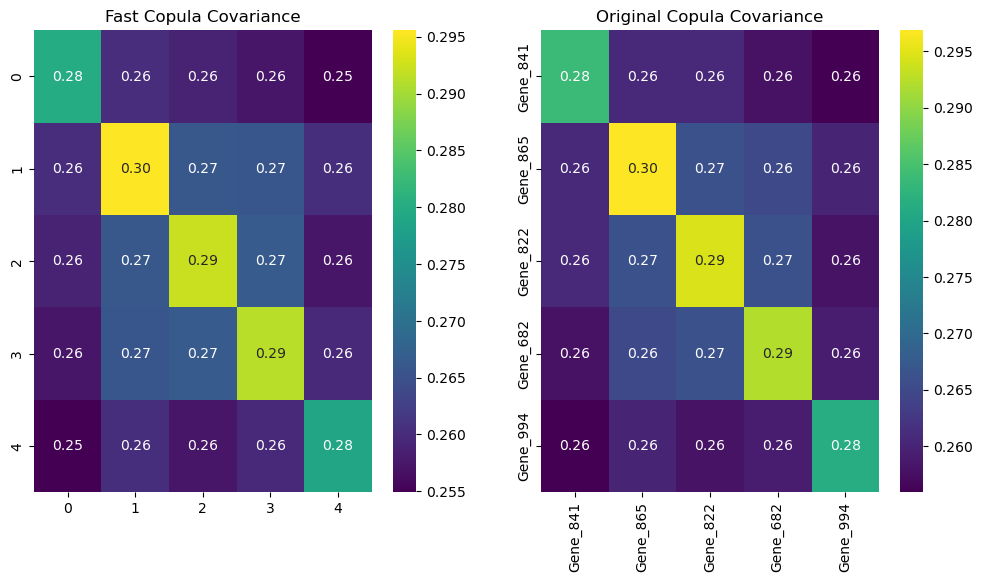

In [10]:
# plot the two covariance matrices
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.heatmap(fast_params['covariance'].top_k_cov, cmap='viridis', annot=True, fmt='.2f')
plt.title('Fast Copula Covariance')
plt.subplot(1, 2, 2)
sns.heatmap(original_params['covariance'], cmap='viridis', annot=True, fmt='.2f')
plt.title('Original Copula Covariance')